set directory

In [2]:
import os
Task_name = 'Assignment1&2 dataset'
data_root = "/home/p88101029/"
raw_data_base = os.path.join(data_root,Task_name)
os.makedirs(raw_data_base, exist_ok=True)

In [3]:
listoffolder=sorted(os.listdir(raw_data_base), reverse=False)

open and save image

In [4]:
import cv2
import numpy as np
from numpy import asarray
images = []
imagescat = []
imagesnames = []
for folder in listoffolder:
    images_path = os.path.join(raw_data_base,folder)
    address = sorted(os.listdir(images_path))
    for imgadd in address:
        imagescat.append(folder)
        imagesnames.append(imgadd)
        img=cv2.imread(os.path.join(images_path,imgadd))
        images.append(asarray(img))


transform image to HOG features

In [5]:
winSize=(64,64)
blockSize=(16,16)
blockStride=(8,8)
cellSize=(8,8)
nbins=9
hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins)

In [6]:
padding=(0,0)
winStride=(8, 8)
imginhog=[]
for i in images:
    img=hog.compute(cv2.resize(i,(64,64)), winStride=winStride, padding=padding)
    imginhog.append(img)

In [7]:
imginhogarr=np.asarray(imginhog).reshape(64225, np.asarray(imginhog).shape[1])
imagescatarr=np.asarray(imagescat)

save / load features dataset

In [8]:
np.save('imginhogarr', imginhogarr)
np.save('imagescatarr', imagescatarr)

In [9]:
import cv2
import numpy as np
from numpy import asarray
imginhogarr=np.load('imginhogarr.npy')
imagescatarr=np.load('imagescatarr.npy')

turn y to one hot vector

In [10]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(imagescatarr)
encoded_imagescatarr = encoder.transform(imagescatarr)
# convert integers to dummy variables (i.e. one hot encoded)
imagescatarr = np_utils.to_categorical(encoded_imagescatarr)

split dataset into train/valid/test

In [420]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import PredefinedSplit
X_trainvalid, X_test, y_trainvalid, y_test = train_test_split(imginhogarr,imagescatarr, test_size=0.1, random_state=0)

split_indext = np.concatenate((np.ones(round(len(y_trainvalid)*0.8)), np.zeros(round(len(y_trainvalid)*0.2))), axis=None).astype(bool)
split_indexv = np.concatenate((np.zeros(round(len(y_trainvalid)*0.8)), np.ones(round(len(y_trainvalid)*0.2))), axis=None).astype(bool)


develop MLP model

In [12]:
from keras import models
from keras import layers
from tensorflow.keras import optimizers
from keras.callbacks import EarlyStopping

network = models.Sequential()
network.add(layers.Dense(545, activation='relu', input_shape=(1764,)))
network.add(layers.Dense(165, activation='relu'))
network.add(layers.Dense(50, activation='softmax'))

network.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

earlyStopping = EarlyStopping(monitor='val_loss', patience=15, verbose=0, mode='min')
history = network.fit(X_trainvalid[split_indext.astype(bool)], y_trainvalid[split_indext.astype(bool)],
                    validation_data=(X_trainvalid[split_indexv.astype(bool)], y_trainvalid[split_indexv.astype(bool)]),
                    epochs=100,batch_size=50,callbacks=earlyStopping)

Epoch 1/100
925/925 [==============================] - 7s 6ms/step - loss: 3.8358 - accuracy: 0.0371 - val_loss: 3.7057 - val_accuracy: 0.0533
Epoch 2/100
925/925 [==============================] - 5s 5ms/step - loss: 3.6620 - accuracy: 0.0659 - val_loss: 3.6172 - val_accuracy: 0.0760
Epoch 3/100
925/925 [==============================] - 4s 4ms/step - loss: 3.5849 - accuracy: 0.0811 - val_loss: 3.5774 - val_accuracy: 0.0817
Epoch 4/100
925/925 [==============================] - 4s 4ms/step - loss: 3.5300 - accuracy: 0.0922 - val_loss: 3.5292 - val_accuracy: 0.0927
Epoch 5/100
925/925 [==============================] - 4s 4ms/step - loss: 3.4924 - accuracy: 0.1015 - val_loss: 3.5176 - val_accuracy: 0.0967
Epoch 6/100
925/925 [==============================] - 4s 5ms/step - loss: 3.4557 - accuracy: 0.1070 - val_loss: 3.4985 - val_accuracy: 0.1008
Epoch 7/100
925/925 [==============================] - 4s 4ms/step - loss: 3.4291 - accuracy: 0.1128 - val_loss: 3.4873 - val_accuracy: 0.0974

plot learning curve

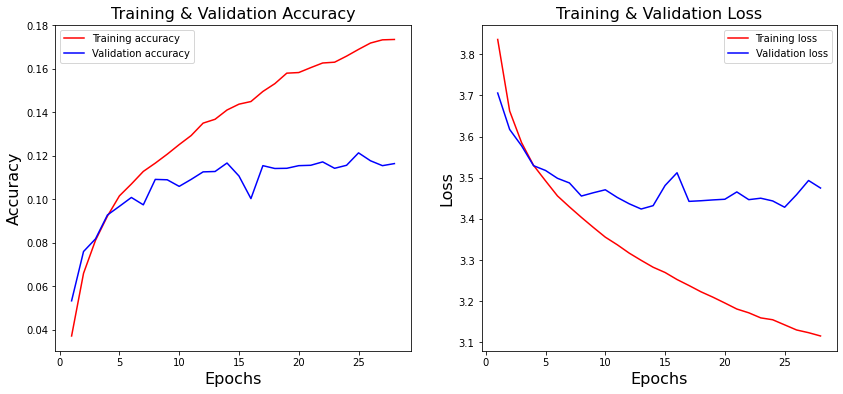

In [13]:
import matplotlib.pyplot as plt
 
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']
 
epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
#
# Plot the model accuracy vs Epochs
#
ax[0].plot(epochs, accuracy, 'r', label='Training accuracy')
ax[0].plot(epochs, val_accuracy, 'b', label='Validation accuracy')
ax[0].set_title('Training & Validation Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend()
#
# Plot the loss vs Epochs
#
ax[1].plot(epochs, loss_values, 'r', label='Training loss')
ax[1].plot(epochs, val_loss_values, 'b', label='Validation loss')
ax[1].set_title('Training & Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()

Comparing predicted vs actual  

the code shown here are for validation  

change '_trainvalid[split_indexv.astype(bool)]' to '_test' for testing

In [14]:
predictions=network.predict(X_trainvalid[split_indexv.astype(bool)])
prediction_ = np.argmax(predictions, axis = 1)
prediction_ = encoder.inverse_transform(prediction_)
actual_ = np.argmax(y_trainvalid[split_indexv.astype(bool)], axis = 1)
actual_ = encoder.inverse_transform(actual_)

In [15]:
# top1 accuracy
np.mean(prediction_==actual_ )

0.11634948096885814

In [16]:
maxfive=np.argsort(predictions, axis=1)[:,-5:]
maxfive

array([[28, 12,  7, 46,  8],
       [28,  2,  0,  7,  8],
       [15, 22, 12, 18, 19],
       ...,
       [46, 22, 19, 44, 49],
       [ 7,  8,  2,  4,  5],
       [14,  7, 40, 19, 12]])

In [17]:
actual= np.argmax(y_trainvalid[split_indexv.astype(bool)], axis = 1).reshape(-1,1)
actual

array([[ 7],
       [ 0],
       [14],
       ...,
       [33],
       [34],
       [ 2]])

In [18]:
# top5 accuracy
np.mean((actual==maxfive).sum(-1))

0.3647923875432526

In [478]:
import numpy as np

class Node:
    def __init__(self):
        self.inputs = None
        self.output = None
        self.gradient = None
        self.next_node_gradient = None

    def forward(self, inputs):
        raise NotImplementedError

    def backward(self):
        raise NotImplementedError

class Linear(Node):
    def __init__(self, weights):
        super().__init__()
        self.weights = weights

    def forward(self):
        self.output = np.dot(self.inputs, self.weights)

    def backward(self):
        self.gradient = np.dot(self.next_node_gradient, self.weights.T)
        self.weights -= np.dot(self.inputs.T, self.next_node_gradient) * learning_rate

class Sigmoid(Node):
    def __init__(self):
        super().__init__()

    def forward(self):
        self.output = 1 / (1 + np.exp(-self.inputs))

    def backward(self):
        self.gradient = self.next_node_gradient * self.output * (1 - self.output)
        
class Relu(Node):
    def __init__(self):
        super().__init__()

    def forward(self):
        self.output = np.maximum(0, self.inputs)

    def backward(self):
        self.gradient = self.next_node_gradient * (self.inputs > 0)

class Softmax(Node):
    def __init__(self):
        super().__init__()

    def forward(self):
        clip = self.inputs.clip(min=None,max=700)
        self.output = np.exp(clip) / np.exp(clip).sum(axis=1) [:,None]

    def backward(self):
        self.gradient = self.output * (self.next_node_gradient -(self.next_node_gradient * self.output).sum(axis=1)[:,None])
        
class NeuralNetwork:
    def __init__(self, num_inputs, num_hidden, num_outputs):
        self.weights1 = np.random.randn(num_inputs, num_hidden)* np.sqrt(2/num_inputs)
        self.input = Linear(self.weights1)
        self.act1 = Relu()
        self.weights2 = np.random.randn(num_hidden, num_outputs)* np.sqrt(2/num_inputs)
        self.hidden = Linear(self.weights2)
        self.act2 = Softmax()
        self.ce = CrossEntropy()
        self.history = []

    def feedforward(self, X):
        self.input.inputs = X
        self.input.forward()
        self.act1.inputs = self.input.output
        self.act1.forward()
        self.hidden.inputs = self.act1.output
        self.hidden.forward()
        self.act2.inputs = self.hidden.output
        self.act2.forward()
        return self.act2.output

    def backpropagate(self, grad):        
        self.act2.next_node_gradient = grad 
        self.act2.backward()
        self.hidden.next_node_gradient = self.act2.gradient
        self.hidden.backward()
        self.act1.next_node_gradient = self.hidden.gradient
        self.act1.backward()
        self.input.next_node_gradient = self.act1.gradient
        self.input.backward()

    def train(self, X, y,Vx,Vy, learning_rate, epochs):
        counter = 0
        bvalacc = 0
        for i in range(epochs):
            output = self.feedforward(X)
            loss = self.ce.forward(output,y)
            grad = self.ce.backward()
            self.backpropagate(grad)
            mloss = np.mean(loss)
            prediction_ = np.argmax(output, axis = 1)
            actual_ = np.argmax(y, axis = 1)
            traacc = np.mean(prediction_==actual_ )
            predictions = self.feedforward(Vx)
            prediction_ = np.argmax(predictions, axis = 1)
            actual_ = np.argmax(Vy, axis = 1)
            valacc = np.mean(prediction_==actual_ )
            if valacc > bvalacc:
                counter = 0
                bvalacc = valacc
            else:
                counter+=1
            print(f'Epoch {i+1}/{epochs}: loss = {mloss}, traacc = {traacc}, valacc = {valacc}')
            self.history.append([i+1,mloss,traacc,valacc])
            if counter == 1000:
                break

    def predict(self, X):
        output = self.feedforward(X)
        return output

class CrossEntropy():
    def __init__(self):
        self.old_x = None
        self.old_y = None
    def forward(self,x,y):
        self.old_x = x.clip(min=1e-8,max=None)
        self.old_y = y
        return (np.where(y==1,-np.log(self.old_x), 0)).sum(axis=1)
    def backward(self):
        return np.where(self.old_y==1,-1/self.old_x, 0)

In [ ]:
network = NeuralNetwork(1764, 128, 50)
learning_rate = 0.00001
epochs = 100000
network.train(X_trainvalid[split_indext], y_trainvalid[split_indext],X_trainvalid[split_indexv], y_trainvalid[split_indexv],learning_rate=learning_rate, epochs=epochs)

Epoch 1/100000: loss = 3.9138147649398465, traacc = 0.018381557891094677, valacc = 0.019982698961937717
Epoch 2/100000: loss = 3.9131849203038565, traacc = 0.019289823104537, valacc = 0.021453287197231833
Epoch 3/100000: loss = 3.9126229424918852, traacc = 0.02032784049132823, valacc = 0.021453287197231833
Epoch 4/100000: loss = 3.9121153542644858, traacc = 0.021387483240344275, valacc = 0.020674740484429067
Epoch 5/100000: loss = 3.9116549585335347, traacc = 0.021387483240344275, valacc = 0.021193771626297576
Epoch 6/100000: loss = 3.9112346828774474, traacc = 0.021538860775917996, valacc = 0.021453287197231833
Epoch 7/100000: loss = 3.9108460669167906, traacc = 0.021538860775917996, valacc = 0.021193771626297576
Epoch 8/100000: loss = 3.9104821732022623, traacc = 0.021538860775917996, valacc = 0.020761245674740483
Epoch 9/100000: loss = 3.9101408952691967, traacc = 0.021733489035941352, valacc = 0.02102076124567474
Epoch 10/100000: loss = 3.9098181190919927, traacc = 0.02197136802041

In [489]:
network.history=np.array(network.history)

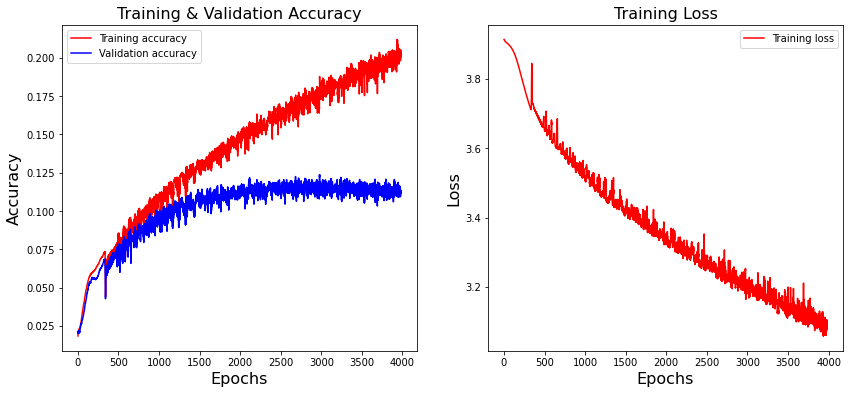

In [492]:
epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
#
# Plot the model accuracy vs Epochs
#
ax[0].plot(network.history[:,0], network.history[:,2], 'r', label='Training accuracy')
ax[0].plot(network.history[:,0], network.history[:,3], 'b', label='Validation accuracy')
ax[0].set_title('Training & Validation Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend()
#
# Plot the loss vs Epochs
#
ax[1].plot(network.history[:,0], network.history[:,1], 'r', label='Training loss')
ax[1].set_title('Training Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()

array([3.91381476, 3.91318492, 3.91262294, ..., 3.10499617, 3.07567123,
       3.09317543])

In [482]:
predictions = network.predict(X_trainvalid[split_indexv.astype(bool)])   
prediction_ = np.argmax(predictions, axis = 1)
prediction_ = encoder.inverse_transform(prediction_)
actual_ = np.argmax(y_trainvalid[split_indexv.astype(bool)], axis = 1)
actual_ = encoder.inverse_transform(actual_)

In [483]:
np.mean(prediction_==actual_ )

0.11280276816608996

In [484]:
maxfive=np.argsort(predictions, axis=1)[:,-5:]
actual= np.argmax(y_trainvalid[split_indexv.astype(bool)], axis = 1).reshape(-1,1)
np.mean((actual==maxfive).sum(-1))

0.35657439446366784

In [485]:
predictions = network.predict(X_test)
prediction_ = np.argmax(predictions, axis = 1)
prediction_ = encoder.inverse_transform(prediction_)
actual_ = np.argmax(y_test, axis = 1)
actual_ = encoder.inverse_transform(actual_)

In [486]:
np.mean(prediction_==actual_ )

0.1175463179199751

In [487]:
maxfive=np.argsort(predictions, axis=1)[:,-5:]
actual= np.argmax(y_test, axis = 1).reshape(-1,1)
np.mean((actual==maxfive).sum(-1))

0.3504592869375681